# Tutorial 1: 10x Visium (DLPFC dataset)

Here we present our re-analysis of 151673 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.This tutorial demonstrates how to identify spatial domains on 10x Visium data using FlatST.

## Import the necessary modules

In [1]:
import scanpy as sc
from sklearn import metrics
import pandas as pd
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import FlatST
import tracemalloc
import time
from sklearn.metrics.cluster import normalized_mutual_info_score

## Set the necessary parameters

In [2]:
# Set parameters
number_list = [151507, 151508, 151509, 151510, 151669, 151670, 151671, 151672, 151673, 151674, 151675, 151676]
regin_num = [7] * 4 + [5] * 4 + [7] * 4
datadir = r'/mnt/mydisk/home/chenxd/lwfx/data/1_DLPFC'
result_path = r'/mnt/mydisk/home/chenxd/lwfx/res/DLPCF'

## Run FlatST

------Calculating spatial graph...
The graph contains 21038 edges, 3611 cells.
5.8261 neighbors per cell on average.


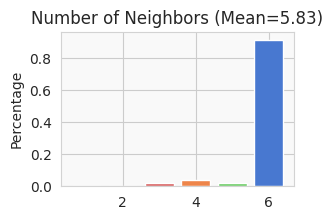

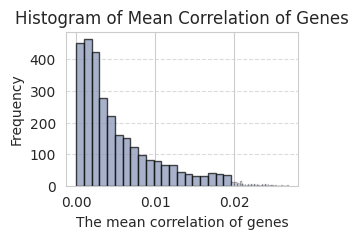

Size of Input:  (3611, 2910)


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Now is slice 151673 , 1 times
memory blocks peak:  751.8354 MB
time: 22.5458 s
ARI:0.6794280914557531 NMI:0.7721770185114232


In [3]:
for k in range(8,9):
    run_num = 1
    slice_num = number_list[k]
    target_num = regin_num[k]
    method = 'FlatST'
    # initial
    memory = [0] * run_num
    during_time = [0] * run_num
    ari_list = [0] * run_num
    nmi_list = [0] * run_num
    # save res
    new_adata = sc.read_h5ad(f'{datadir}/{slice_num}.h5ad')

    for i in range(run_num):
        tracemalloc.start()
        start_time = time.time()

        adata = sc.read_h5ad(f'{datadir}/{slice_num}.h5ad')
        adata.var_names_make_unique()
        adata = adata[~adata.obs.isna().any(axis=1)].copy()
        
        # Normalization
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

        # Constructing the spatial network
        FlatST.Cal_Spatial_Net(adata, rad_cutoff=150)
        FlatST.Stats_Spatial_Net(adata)
        
        # Running FlatST
        adata = FlatST.train_FlatST(adata,n_epochs=1000,hidden_dims=[610,10],cuda_device=2,
                                    num_smooth_iterations=[5,0],keep_percent=0.97,initial_alpha=1.0,is_distribution=1.0,is_early_stopping=0) 
        adata = FlatST.mclust_R(adata, used_obsm='FlatST', num_cluster=target_num)
        
        # Save relevant data
        new_adata.obs['pred_{}'.format(i+1)]=adata.obs['mclust']
        obs_df = adata.obs.dropna()
        ari = adjusted_rand_score(obs_df['mclust'], obs_df['Region'])
        nmi = normalized_mutual_info_score(obs_df['mclust'], obs_df['Region'])
        ari_list[i] = ari
        nmi_list[i] = nmi
        end_time = time.time()
        during = end_time - start_time

        size, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        memory[i] = peak / 1024 / 1024
        during_time[i] = during

        print('Now is slice {} , {} times'.format(slice_num,i+1))
        print('memory blocks peak:{:>10.4f} MB'.format(memory[i]))
        print('time: {:.4f} s'.format(during_time[i]))
        print('ARI:{}'.format(ari_list[i]), 'NMI:{}'.format(nmi))

    new_adata.uns['time'] = during_time
    new_adata.uns['memory'] = memory
    new_adata.uns['ari'] = ari_list
    new_adata.uns['nmi'] = nmi_list
    new_adata.write(f'{result_path}/{method}_{slice_num}.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'FlatST'

## Find the best-performing model

In [5]:
# adata  = sc.read_h5ad(f'{result_path}/{method}_{slice_num}.h5ad')
adata = new_adata
ari_array = np.array(adata.uns['ari'])
a,a_loc = np.max(ari_array),np.argmax(ari_array)
b,b_loc = np.min(ari_array),np.argmin(ari_array)
print('max ARI is {:.2f}, loc is {}'.format(a,a_loc+1))

max ARI is 0.68, loc is 1


## Draw the result

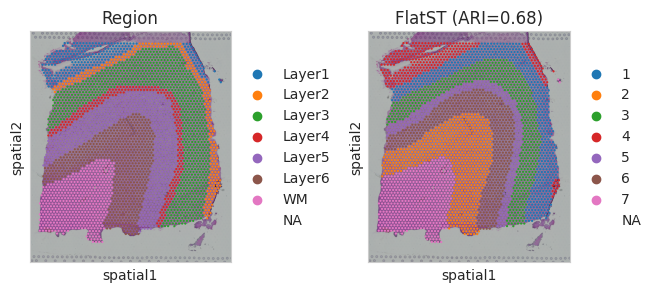

In [6]:
# The best
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["Region","pred_" + str(a_loc+1)], title=["Region",'FlatST (ARI=%.2f)'%a])

## Match colors

In [7]:
adata = adata[~adata.obs['Region'].isna()]
pred = 'pred_{}'.format(a_loc+1)
dic = FlatST.find_region_mapping(adata,pred)
dic

{2: 'Layer6',
 3: 'Layer3',
 6: 'Layer5',
 7: 'WM',
 4: 'Layer1',
 1: 'Layer2',
 5: 'Layer4'}

In [8]:
# Map the numerical label of mclust to the Layer name
adata.obs['mclust'] = adata.obs[pred].map(dic)
# Force the category order of mclust to be exactly the same as that of Region
region_order = adata.obs['Region'].astype('category').cat.categories.tolist()
adata.obs['mclust'] = pd.Categorical(
    adata.obs['mclust'], 
    categories=region_order  # Key: Align the order with Region
)

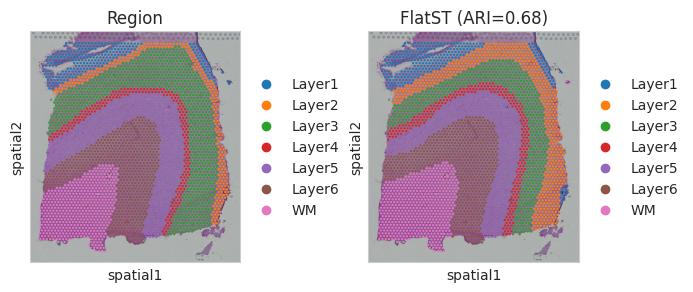

In [9]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["Region","mclust"], title=["Region",'FlatST (ARI=%.2f)'%a])

## Run_umap

------Calculating spatial graph...
The graph contains 21038 edges, 3611 cells.
5.8261 neighbors per cell on average.


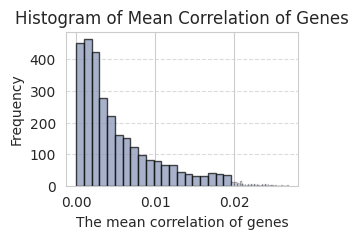

Size of Input:  (3611, 2910)


100%|██████████| 1000/1000 [00:14<00:00, 70.97it/s]

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


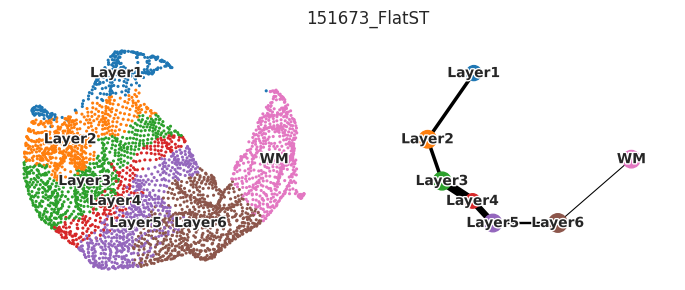

In [ ]:
for k in range(8,9):
    run_num = 1
    slice_num = number_list[k]
    target_num = regin_num[k]
    method = 'FlatST'
    adata = sc.read_h5ad(f'{datadir}/{slice_num}.h5ad')

    for i in range(run_num):
        adata = sc.read_h5ad(f'{datadir}/{slice_num}.h5ad')
        adata.var_names_make_unique()
        adata = adata[~adata.obs.isna().any(axis=1)].copy()
        # Normalization
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

        # Constructing the spatial network
        FlatST.Cal_Spatial_Net(adata, rad_cutoff=150)

        # Running FlatST
        adata = FlatST.train_FlatST(adata,n_epochs=1000,hidden_dims=[610,10],cuda_device=2,
                                    num_smooth_iterations=[5,0],keep_percent=0.97,initial_alpha=1.0,is_distribution=1.0,is_early_stopping=0) 
        adata = FlatST.mclust_R(adata, used_obsm='FlatST', num_cluster=target_num)

    adata = adata[~adata.obs['Region'].isna()]
    sc.pp.neighbors(adata, use_rep='FlatST')
    sc.tl.umap(adata)
    
    pred = 'mclust'
    dic = FlatST.find_region_mapping(adata, pred)
    adata.obs['mclust'] = adata.obs[pred].map(dic)
    region_order = adata.obs['Region'].astype('category').cat.categories.tolist()
    adata.obs['mclust'] = pd.Categorical(
        adata.obs['mclust'],
        categories=region_order
    )
    
    used_adata = adata[adata.obs['mclust']!='nan',]
    used_adata = used_adata[used_adata.obs['mclust'].notna()]
    
    sc.tl.paga(used_adata, groups='mclust')
    plt.rcParams["figure.figsize"] = (4,3)
    sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                    title=str(slice_num)+'_FlatST', legend_fontoutline=2, show=False)